In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!echo '{"username":"kushgabani","key":"2d5beec462b167cbb153b799f07b04f1"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia/

100% 2.29G/2.29G [00:50<00:00, 45.8MB/s]
100% 2.29G/2.29G [00:50<00:00, 49.1MB/s]


In [5]:
!unzip /content/chest-xray-pneumonia.zip  -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: datase

In [7]:
%tensorflow_version 2.x
# Tools for working with directories
import os
import warnings
import glob
import shutil

# Tools for data manipulation and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tools for working with images
import cv2
from google.colab.patches import cv2_imshow

# Evaluation metrics and splitting data
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Keras API for Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Input, Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

warnings.filterwarnings("ignore")

In [12]:
# Paths for both training and testing path
training_path = "./dataset/chest_xray/train/"
testing_path = "./dataset/chest_xray/test/"
validation_path = "./dataset/chest_xray/val/"

shutil.rmtree("./dataset/chest_xray/__MACOSX/")
shutil.rmtree("./dataset/chest_xray/chest_xray/")

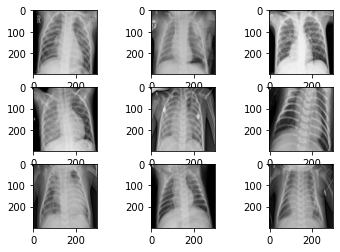

In [10]:
# Plotting a few sample images
def plot_sample_data():
  sample_images = []
  for r, _, f in os.walk(training_path + "PNEUMONIA"):
    for image in f[:9]:
      sample_images.append(image)

  for i in range(9):
      plt.subplot(3, 3, i + 1)
      plt.rcParams["figure.figsize"] = (20, 20)
      img = cv2.imread(training_path + "PNEUMONIA/" + sample_images[i])
      img = cv2.resize(img, (300, 300))
      plt.imshow(img)

plot_sample_data()

In [13]:
# Dimension of input images 150 x 150 
DIMENSIONS = 150

def get_training_testing_data():
  # Total number of samples in training and testing
  training_samples_len = len(os.listdir(training_path + "NORMAL/")) + len(os.listdir(training_path + "PNEUMONIA/"))
  testing_samples_len = len(os.listdir(testing_path + "NORMAL/")) + len(os.listdir(testing_path + "PNEUMONIA/"))
  validation_samples_len = len(os.listdir(validation_path + "NORMAL/")) + len(os.listdir(validation_path + "PNEUMONIA/"))
  
  # Initialising X_train, y_train, X_test, y_test
  X_train = np.zeros((training_samples_len, DIMENSIONS, DIMENSIONS))
  y_train = np.zeros((training_samples_len))

  X_test = np.zeros((testing_samples_len, DIMENSIONS, DIMENSIONS))
  y_test = np.zeros((testing_samples_len))

  X_valid = np.zeros((validation_samples_len, DIMENSIONS, DIMENSIONS))
  y_valid = np.zeros((validation_samples_len))

  # Converting and resizing images in 150 x 150 and storing it in X_train and its corresponding labels in y_train
  for cat in ["NORMAL", "PNEUMONIA"]:
    for r, _, files in os.walk(training_path + cat + "/"):
      for i, image in enumerate(files):
        # Converting the images to Grayscale
        img = cv2.imread(training_path + cat + "/" + image, cv2.IMREAD_GRAYSCALE)

        # Resizing the image to the needed dimensions
        img = cv2.resize(img, (DIMENSIONS, DIMENSIONS))

        # Storing images and its corresponding labels in numpy arrays
        X_train[i] = img
        y_train[i] = (0 if cat == "NORMAL" else 1)

  # Converting and resizing images in 150 x 150 and storing it in X_test and its corresponding labels in y_test
  for cat in ["NORMAL", "PNEUMONIA"]:
    for r, _, files in os.walk(testing_path + cat + "/"):
      for i, image in enumerate(files):
        # Converting the images to Grayscale
        img = cv2.imread(testing_path + cat + "/" + image, cv2.IMREAD_GRAYSCALE)

        # Resizing the image to the needed dimensions
        img = cv2.resize(img, (DIMENSIONS, DIMENSIONS))

        # Storing images and its corresponding labels in numpy arrays
        X_test[i] = img
        y_test[i] = (0 if cat == "NORMAL" else 1)

  # Converting and resizing images in 150 x 150 and storing it in X_valid and its corresponding labels in y_valid
  for cat in ["NORMAL", "PNEUMONIA"]:
    for r, _, files in os.walk(validation_path + cat + "/"):
      for i, image in enumerate(files):
        # Converting the images to Grayscale
        img = cv2.imread(validation_path + cat + "/" + image, cv2.IMREAD_GRAYSCALE)

        # Resizing the image to the needed dimensions
        img = cv2.resize(img, (DIMENSIONS, DIMENSIONS))

        # Storing images and its corresponding labels in numpy arrays
        X_test[i] = img
        y_test[i] = (0 if cat == "NORMAL" else 1)

  # Normalising data - dividing it by 255
  return X_train / 255.0, y_train, X_test / 255.0, y_test, X_valid / 255.0, y_valid

X_train, y_train, X_test, y_test, X_valid, y_valid = get_training_testing_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

((5216, 150, 150), (5216,), (624, 150, 150), (624,), (16, 150, 150), (16,))

<BarContainer object of 2 artists>

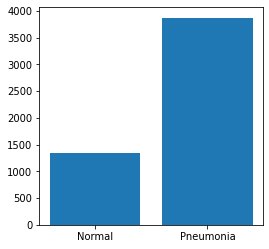

In [16]:
# Checking the number of samples in both the classes before data augmentation
_, count = np.unique(y_train, return_counts = True)
plt.rcParams["figure.figsize"] = (4 , 4)
plt.bar(["Normal", "Pneumonia"], count)

In [17]:
X_train = X_train.reshape(-1, DIMENSIONS, DIMENSIONS, 1)
X_test = X_test.reshape(-1, DIMENSIONS, DIMENSIONS, 1)
X_valid = X_valid.reshape(-1, DIMENSIONS, DIMENSIONS, 1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

((5216, 150, 150, 1),
 (5216,),
 (624, 150, 150, 1),
 (624,),
 (16, 150, 150, 1),
 (16,))

In [18]:
# Data Augmentation as we have class imbalance problem
datagen = ImageDataGenerator(rotation_range = 20,
                                   zoom_range = 0.3,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True)

datagen.fit(X_train)

In [21]:
# One Hot Encoding the labels of both training and testing samples
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
y_valid = to_categorical(y_valid, num_classes = 2)

In [55]:
# Assembling our Neural Network Architecture
def create_model(lr = 3e-4, dec = 1e-5):
  model = Sequential([
               # Specifications for the Input Layer and the first Convolution Layer
               Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", name = "Conv1", activation = "relu", input_shape = (DIMENSIONS, DIMENSIONS, 1)),
               MaxPool2D(pool_size=(2, 2), name = "MaxPool1"),

               # Second convolution layer
               Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", name = "Conv2_1", activation = "relu"),
               BatchNormalization(),
               Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", name = "Conv2_2", activation = "relu"),
               BatchNormalization(),
               MaxPool2D(pool_size=(2, 2), name = "MaxPool2"),

               # Third convolution layer
               Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", name = "Conv3_1", activation = "relu"),
               BatchNormalization(),
               Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", name = "Conv3_2", activation = "relu"),
               BatchNormalization(),
               MaxPool2D(pool_size=(2, 2), name = "MaxPool3"),

               # Fourth convolution layer
               Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", name = "Conv4", activation = "relu"),
               BatchNormalization(),
               MaxPool2D(pool_size=(2, 2), name = "MaxPool4"),
  
               # Fifth convolution layer
               Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", name = "Conv5", activation = "relu"),
               BatchNormalization(),
               MaxPool2D(pool_size=(2, 2), name = "MaxPool5"),

               # Neural Network
               Flatten(name = "Flatten"),
               Dense(128, activation = "relu", name = "Dense1"),
               Dropout(0.3),

               # Output Layer for the Neural Network
               Dense(2, activation = "softmax", name = "Output")
  ])

  # Specifying Loss function, optimizer with learning rate and the evaluation metric
  model.compile(optimizer = Adam(lr = lr, decay = dec),
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  return model

In [58]:
model = create_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 150, 150, 32)      320       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 75, 75, 32)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_60 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 75, 75, 64)        36928     
_________________________________________________________________
batch_normalization_61 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 37, 37, 64)       

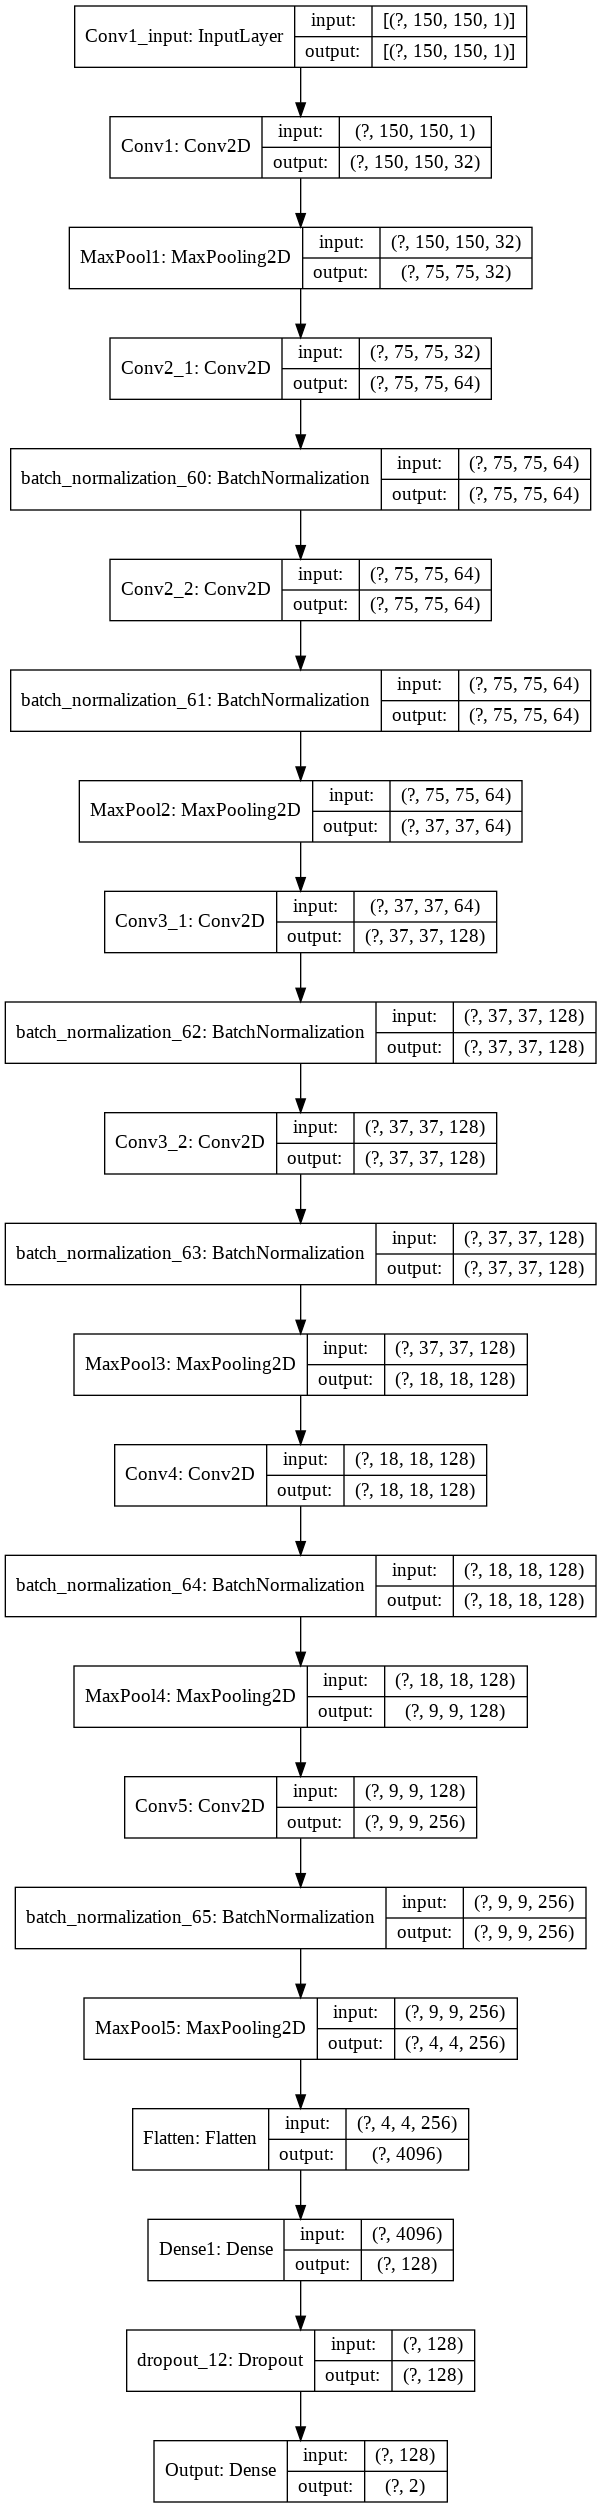

In [59]:
# Plotting the CNN Architecture in a diagram
plot_model(model, show_shapes=True, show_layer_names = True)

In [60]:
def train_model(model, epochs, batch_size):
  # Reducing learning rate when the model takes a flat road during training
  reduced_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.3,
                                            patience=10,
                                            verbose=1,
                                            mode='min',
                                            min_lr=0.00001)
  
  # Training the model on the training set
  history = model.fit(datagen.flow(X_train, y_train, batch_size = batch_size),
                      epochs = epochs,
                      validation_data = datagen.flow(X_valid, y_valid),
                      callbacks = [reduced_learning_rate])
  return history

history = train_model(model, 1, 32)

163/163 [==============================] - 10s 62ms/step - loss: 0.0221 - accuracy: 0.9952 - val_loss: 2.3842e-06 - val_accuracy: 1.0000


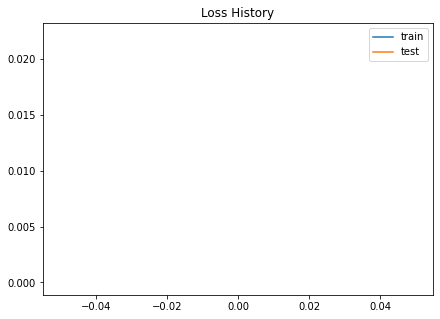

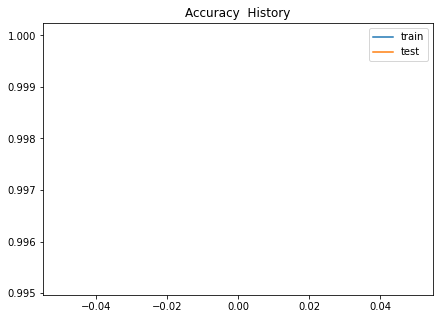

In [61]:
# Plotting Loss and Accuracy graph for both training and testing data
def plot_loss_accuracy(history):
  plt.rcParams['figure.figsize'] = (7, 5)
  plt.plot(history.history["loss"], label = "train")
  plt.plot(history.history["val_loss"], label = "test")
  plt.legend()  
  plt.title("Loss History")
  plt.show()

  plt.rcParams['figure.figsize'] = (7, 5)
  plt.plot(history.history["accuracy"], label = "train")
  plt.plot(history.history["val_accuracy"], label = "test")
  plt.title("Accuracy  History")
  plt.legend()
  plt.show()

plot_loss_accuracy(history)

In [62]:
# Checking the accuracy of the model
y_preds = model.predict(X_test)
predictions = np.argmax(y_preds, axis = 1)  # Getting the index corresponding to the output
ground_truth = np.where(y_test == 1)[1]  # Getting index of the class of the Corresponding OneHot Encode

# Evaluating the model using metrics like Precision Score, Recall Score, F1-score
prec_score = precision_score(ground_truth, predictions)
rec_score = recall_score(ground_truth, predictions)
f_score = f1_score(ground_truth, predictions)
print(f"Precision score : {prec_score * 100}%")
print(f"Recall score : {rec_score * 100}%")
print(f"F1 score : {f_score * 100}%")

# Showing a classification report
print(classification_report(ground_truth, predictions))

Precision score : 0.0%
Recall score : 0.0%
F1 score : 0.0%
              precision    recall  f1-score   support

           0       0.38      1.00      0.55       234
           1       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



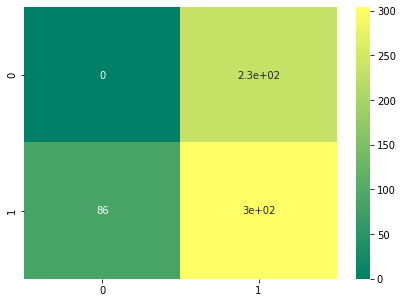

In [ ]:
# Plotting confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)
sns.heatmap(conf_matrix, cmap= "summer", annot = True);

In [ ]:
# Saving the model
model.save("Pneumonia-detection-model", save_format = "h5")

In [ ]:
ind = 34
y_preds = model.predict(X_test[ind].reshape(1, 100, 100, 3))
y_preds

array([[0.04640595, 0.9535941 ]], dtype=float32)

In [ ]:
y_test[ind]

array([0., 1.], dtype=float32)